In [1]:
#import os
#import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
# import torch
# from torch import nn
# from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import sys
sys.path.insert(0, "../code")   
from model_utils import train


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
# load
df = pd.read_excel("../output/data/scaled_train_nonoverlap_top_10_store_item_X_y.xlsx")
df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.37344,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.248855,0.293631,0.37344,0.018270,0.018576,0.040971,0.030303,0.027815,0.068742,0.069051
2,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.248855,0.293631,0.37344,0.060901,0.074303,0.110774,0.056818,0.047682,0.089494,0.123305
3,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.248855,0.293631,0.37344,0.123021,0.160991,0.201821,0.155303,0.156291,0.280156,0.314427
4,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.248855,0.293631,0.37344,0.210719,0.243034,0.295903,0.301136,0.196026,0.315175,0.383477


In [4]:
df.dtypes

date                 datetime64[ns]
store_item                   object
store                         int64
item                          int64
sales_day_1                 float64
sales_day_2                 float64
sales_day_3                 float64
sales_day_4                 float64
sales_day_5                 float64
sales_day_6                 float64
sales_day_7                 float64
store_med_day_1             float64
store_med_day_2             float64
store_med_day_3             float64
store_med_day_4             float64
store_med_day_5             float64
store_med_day_6             float64
store_med_day_7             float64
item_med_day_1              float64
item_med_day_2              float64
item_med_day_3              float64
item_med_day_4              float64
item_med_day_5              float64
item_med_day_6              float64
item_med_day_7              float64
y_sales_day_1               float64
y_sales_day_2               float64
y_sales_day_3               

In [5]:
df.columns

Index(['date', 'store_item', 'store', 'item', 'sales_day_1', 'sales_day_2',
       'sales_day_3', 'sales_day_4', 'sales_day_5', 'sales_day_6',
       'sales_day_7', 'store_med_day_1', 'store_med_day_2', 'store_med_day_3',
       'store_med_day_4', 'store_med_day_5', 'store_med_day_6',
       'store_med_day_7', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3',
       'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7',
       'y_sales_day_1', 'y_sales_day_2', 'y_sales_day_3', 'y_sales_day_4',
       'y_sales_day_5', 'y_sales_day_6', 'y_sales_day_7', 'y_store_med_day_1',
       'y_store_med_day_2', 'y_store_med_day_3', 'y_store_med_day_4',
       'y_store_med_day_5', 'y_store_med_day_6', 'y_store_med_day_7',
       'y_item_med_day_1', 'y_item_med_day_2', 'y_item_med_day_3',
       'y_item_med_day_4', 'y_item_med_day_5', 'y_item_med_day_6',
       'y_item_med_day_7'],
      dtype='object')

In [6]:
feature_cols = (
    [f"sales_day_{i}"     for i in range(1, 8)]  # 7 cols
  + [f"store_med_day_{i}" for i in range(1, 8)]  # 7 cols
  + [f"item_med_day_{i}"  for i in range(1, 8)]  # 7 cols
)
label_cols = (
    [f"y_sales_day_{i}"     for i in range(1,8)]
  + [f"y_store_med_day_{i}" for i in range(1,8)]
  + [f"y_item_med_day_{i}"  for i in range(1,8)]
)
# # … shift & drop to build X, y …
df = df.dropna(subset=[f'y_{c}' for c in feature_cols]).reset_index(drop=True)
df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.37344,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.248855,0.293631,0.37344,0.018270,0.018576,0.040971,0.030303,0.027815,0.068742,0.069051
2,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.248855,0.293631,0.37344,0.060901,0.074303,0.110774,0.056818,0.047682,0.089494,0.123305
3,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.248855,0.293631,0.37344,0.123021,0.160991,0.201821,0.155303,0.156291,0.280156,0.314427
4,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.248855,0.293631,0.37344,0.210719,0.243034,0.295903,0.301136,0.196026,0.315175,0.383477


In [7]:
weights_df= pd.read_excel("../output/data/top_10_item_weights.xlsx")

In [8]:
weights_df

,item,weight
0,114790,1.00
1,305229,1.00
2,314384,1.00
3,364606,1.00
4,502331,1.25
5,567623,1.00
6,581078,1.00
7,582864,1.25
8,584028,1.25
9,1047679,1.00


In [31]:
sid =  "3_1047679"
item = 1047679
df[df["store_item"] == sid]
weights_df[weights_df["item"] == item]

,item,weight
9,1047679,1.0


In [55]:
sub = (
    df[df["store_item"] == sid]
    .sort_values("date")
    .reset_index(drop=True)
    .merge(weights_df, on="item", how="left")
)
sub
n_missing = sub['weight'].isna().sum()
print(f"Found {n_missing} missing weights")


Found 0 missing weights


In [116]:
import os
import torch
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from typing import List, Tuple, Dict
from model_utils import ShallowNN, NWRMSLELoss

def train(
    df: pd.DataFrame,
    weights_df: pd.DataFrame,
    feature_cols: List[str],
    label_cols:   List[str],
    item_col:     str,
    train_frac:   float  = 0.8,
    batch_size:   int    = 32,
    lr:           float  = 1e-3,
    epochs:       int    = 5,
    seed:         int    = 2025,
    model_dir:    str    = "../output/models/",
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, torch.nn.Module]]:
    """
    Trains a separate ShallowNN on each store_item's time series (no CV),
    does an 80/20 split by time, saves each model, and returns:
      - hist_df: per-epoch train/test losses
      - summary_df: final losses by store_item
      - models: dict mapping store_item -> trained model (on CPU)
    """
    torch.manual_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(model_dir, exist_ok=True)

    history = []
    models: Dict[str, torch.nn.Module] = {}

    for sid in df['store_item'].unique():
        # --- Prepare sid-specific data
        sub = (df[df['store_item']==sid]
               .sort_values('date')
               .reset_index(drop=True)
               .merge(weights_df, on=item_col, how='left'))

        X = sub[feature_cols].to_numpy(float)
        y = sub[label_cols].to_numpy(float)
        w = sub['weight'].to_numpy(float).reshape(-1,1)

        print("Weight summary:")
        print(sub['weight'].describe())            # gives count, mean, min, max, etc.
        n_zero = (sub['weight'] == 0).sum()
        print(f" → {n_zero} rows have weight == 0")

        # train/test 80/20 by time
        train_size = int(len(sub) * train_frac)
        X_tr, X_te = X[:train_size], X[train_size:]
        y_tr, y_te = y[:train_size], y[train_size:]
        w_tr, w_te = w[:train_size], w[train_size:]
        # print(f"Training on {sid}: {len(X_tr)} train, {len(X_te)} test")
        # print(f"  Y size: {y_tr.shape}, test size: {y_te.shape}")
        # print(f"  W size: {w_tr.shape}, test size: {w_te.shape}")
        # # Now after you split into training/test:
        # print("Test-set weight stats:")
        # print(pd.Series(w_te.flatten()).describe())
        # print(f"Test-set total weight sum: {w_te.sum():.4f}")

        # DataLoaders
        ds_tr = TensorDataset(torch.from_numpy(X_tr).float(),
                              torch.from_numpy(y_tr).float(),
                              torch.from_numpy(w_tr).float())
        ds_te = TensorDataset(torch.from_numpy(X_te).float(),
                              torch.from_numpy(y_te).float(),
                              torch.from_numpy(w_te).float())
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=False)
        ld_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False)

        # init model, loss, optimizer
        model   = ShallowNN(input_dim=len(feature_cols)).to(device)
        loss_fn = NWRMSLELoss()
        optim   = torch.optim.Adam(model.parameters(), lr=lr)

        # train epochs
        for epoch in range(1, epochs+1):
            # train
            model.train()
            tr_loss_acc = 0.0
            for xb,yb,wb in ld_tr:
                xb,yb,wb = xb.to(device), yb.to(device), wb.to(device)
                preds = model(xb)
                loss  = loss_fn(preds, yb, wb)
                optim.zero_grad(); loss.backward(); optim.step()
                tr_loss_acc += loss.item()*xb.size(0)
            tr_loss = tr_loss_acc / len(ds_tr)

            # test
            model.eval()
            num, den = 0.0, 0.0
            with torch.no_grad():
                for xb,yb,wb in ld_te:
                    xb,yb,wb = xb.to(device), yb.to(device), wb.to(device)
                    p = model(xb).clamp(min=1e-6)
                    if torch.any(p < 0) or torch.any(p > 1):
                        p_min, p_max = p.min().item(), p.max().item()
                        print(f"p out of [0,1] range: min={p_min:.6f}, max={p_max:.6f}")
                    ld = torch.log(p+1) - torch.log(yb+1)
                    if torch.isnan(ld).any():
                        # report which batch and stats
                        nan_mask = torch.isnan(ld)
                        num_nans = nan_mask.sum().item()
                        print(f"⚠️ Found {num_nans} NaNs in ld")
                        # inspect the offending values
                        print("p sample:", p[nan_mask.nonzero(as_tuple=True)])
                        print("y sample:", yb[nan_mask.nonzero(as_tuple=True)])
                    
                    num += (wb*ld**2).sum().item()
                    den += wb.sum().item()
            te_loss = (num/den)**0.5

            history.append({
                'store_item': sid,
                'epoch':      epoch,
                'train_loss': tr_loss,
                'test_loss':  te_loss
            })
            print(f"[{sid}] Epoch {epoch}/{epochs} — train {tr_loss:.4f}, test {te_loss:.4f}")

        # save to disk
        save_path = os.path.join(model_dir, f"model_{sid}.pth")
        torch.save({
            'sid': sid,
            'model_state_dict': model.cpu().state_dict(),
            'feature_cols':     feature_cols,
            'label_cols':       label_cols,
            'train_frac':       train_frac,
            'epochs':           epochs,
        }, save_path)
        print(f"Saved model for {sid} to {save_path}")

        # keep in memory (on CPU) as well
        models[sid] = model.cpu()

    # build DataFrames
    hist_df = pd.DataFrame(history)
    summary_df = (
        hist_df
        .groupby('store_item')
        .agg(final_train_loss=('train_loss','last'),
             final_test_loss =('test_loss','last'))
        .reset_index()
    )

    return hist_df, summary_df, models


In [117]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [118]:
df2= df.query('store_item == "3_1047679"')
df2

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.373440,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
100,2013-01-14,3_1047679,3,1047679,0.370635,0.099245,0.067611,0.029903,0.287365,0.652988,...,0.233335,0.264983,0.296819,0.434836,0.191950,0.206373,0.272727,0.214570,0.282750,0.514180
200,2013-01-21,3_1047679,3,1047679,0.461111,0.074649,0.086751,0.156117,0.161733,0.463872,...,0.379813,0.355046,0.342084,0.080390,0.199690,0.147193,0.196970,0.209272,0.363165,0.329223
300,2013-01-28,3_1047679,3,1047679,0.199206,0.065156,0.071588,0.128932,0.391336,0.333631,...,0.225370,0.306709,0.184635,0.225335,0.202786,0.209408,0.225379,0.182781,0.225681,0.124538
400,2013-02-04,3_1047679,3,1047679,0.247619,0.076160,0.065374,0.104854,0.340072,0.325602,...,0.309908,0.354130,0.308045,0.152253,0.241486,0.210926,0.170455,0.135099,0.172503,0.186190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23399,2017-07-11,3_1047679,3,1047679,0.257937,0.057174,0.067860,0.117670,0.267870,0.435326,...,0.357892,0.246844,0.215483,0.250914,0.294118,0.256449,0.337121,0.425166,0.485084,0.204686
23499,2017-07-18,3_1047679,3,1047679,0.378571,0.089752,0.071588,0.135534,0.288809,0.529884,...,0.223454,0.218043,0.236825,0.222899,0.280186,0.236722,0.350379,0.425166,0.404669,0.236745
23599,2017-07-25,3_1047679,3,1047679,0.228571,0.072708,0.061894,0.128932,0.311191,0.331847,...,0.217243,0.326331,0.205293,0.489647,0.679567,0.511381,0.784091,0.529801,0.596628,0.300863
23699,2017-08-01,3_1047679,3,1047679,0.234127,0.091694,0.128262,0.181359,0.319856,0.314005,...,0.205472,0.204663,0.192660,0.181486,0.354489,0.330804,0.583333,0.369536,0.324254,0.271270


In [121]:
df2.dropna(subset=label_cols, inplace=True)


/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_94708/774117504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(subset=label_cols, inplace=True)


In [9]:
hist_df, summary_df, models_dict = train(
    df            = df,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    item_col      = "item",
    train_frac    = 0.8,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 50,
    seed          = 2025,
    model_dir     = "../output/models/"
)

[3_1047679] Epoch 1/50 — train 1.0037, test 0.8798
[3_1047679] Epoch 2/50 — train 0.8509, test 0.7834
[3_1047679] Epoch 3/50 — train 0.7636, test 0.7265
[3_1047679] Epoch 4/50 — train 0.7042, test 0.6933
[3_1047679] Epoch 5/50 — train 0.6776, test 0.6872
[3_1047679] Epoch 6/50 — train 0.6706, test 0.6831
[3_1047679] Epoch 7/50 — train 0.6651, test 0.6776
[3_1047679] Epoch 8/50 — train 0.6595, test 0.6734
[3_1047679] Epoch 9/50 — train 0.6548, test 0.6714
[3_1047679] Epoch 10/50 — train 0.6515, test 0.6704
[3_1047679] Epoch 11/50 — train 0.6487, test 0.6691
[3_1047679] Epoch 12/50 — train 0.6460, test 0.6679
[3_1047679] Epoch 13/50 — train 0.6437, test 0.6671
[3_1047679] Epoch 14/50 — train 0.6418, test 0.6666
[3_1047679] Epoch 15/50 — train 0.6399, test 0.6661
[3_1047679] Epoch 16/50 — train 0.6380, test 0.6653
[3_1047679] Epoch 17/50 — train 0.6361, test 0.6644
[3_1047679] Epoch 18/50 — train 0.6344, test 0.6636
[3_1047679] Epoch 19/50 — train 0.6328, test 0.6629
[3_1047679] Epoch 20/

In [10]:
hist_df.head(3)


,store_item,epoch,train_loss,test_loss
0,3_1047679,1,1.003697,0.879810
1,3_1047679,2,0.850915,0.783355
2,3_1047679,3,0.763588,0.726506


In [11]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss
0,3_1047679,0.615603,0.654655
1,3_114790,0.509250,0.492330
2,3_305229,0.458044,0.456137


In [12]:


def plot_loss_per_sid(hist_df, sid, fn):
    """
    Plot train and test loss vs. epoch for a given store_item (sid),
    save to file `fn`.
    """
    df = hist_df[hist_df["store_item"] == sid].sort_values("epoch")
    if df.empty:
        raise ValueError(f"No data found for store_item = {sid!r}")

    fig, ax = plt.subplots(figsize=(12, 5))

    # plot
    ax.plot(df["epoch"], df["train_loss"], marker="o", label="Train Loss")
    ax.plot(df["epoch"], df["test_loss"],  marker="o", label="Validation Loss")

    # titles & labels
    ax.set_title(f"Loss Curves for {sid}", fontsize=24, fontweight="bold")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

    # ticks exactly at each epoch
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(df["epoch"].min(), df["epoch"].max())  # clamp x-axis

    # y-axis ticks
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))

    # grid, legend
    ax.grid(True, which="major", linestyle="--", alpha=0.5)
    ax.legend()

    # tick styling
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='major', length=6)
    ax.tick_params(axis='y', which='minor', length=4)

    plt.tight_layout(pad=2)
    plt.savefig(fn, dpi=300)
    plt.show()
    plt.close(fig)


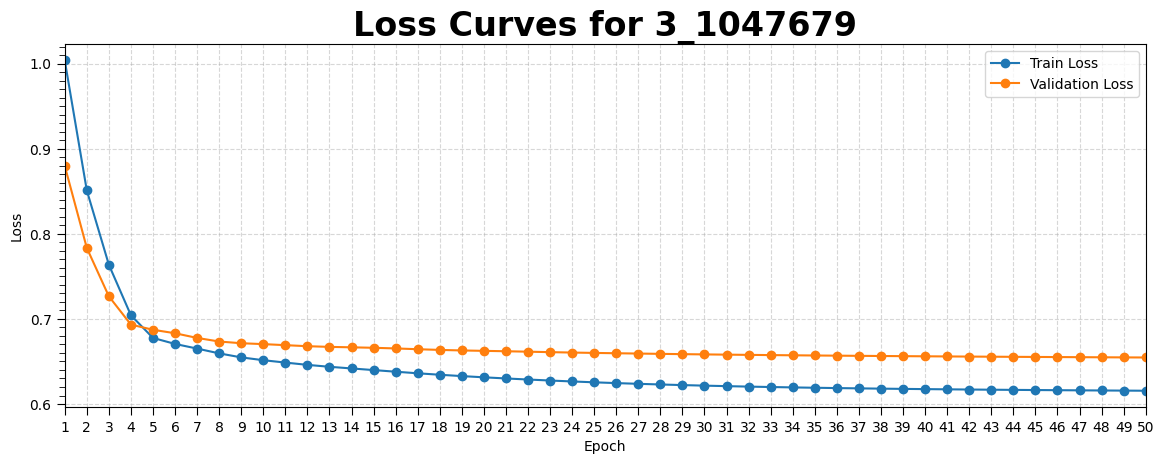

In [13]:
# to plot a single sid:
sid = "3_1047679"
plot_loss_per_sid(hist_df, sid=sid, fn=f"../output/figures/loss_curves_{sid}.tiff")

# # if you want to loop over all sids:
# for sid in hist_df["store_item"].unique():
#     plot_loss_per_sid(hist_df, sid)


In [14]:

def plot_all_sids_losses(hist_df, overall_title=None, fn=None):
    sids   = hist_df["store_item"].unique()
    epochs = sorted(hist_df["epoch"].unique())
    
    fig, (ax_tr, ax_te) = plt.subplots(2,1, figsize=(12,8), sharex=True)

    # — Train Loss —
    for sid in sids:
        df_sid = hist_df[hist_df["store_item"]==sid]
        ax_tr.plot(df_sid["epoch"], df_sid["train_loss"],
                   marker="o", linewidth=1, label=sid)
    ax_tr.set_title("Train Loss by Epoch", fontsize=16, fontweight="bold")
    ax_tr.set_ylabel("Train Loss")
    ax_tr.grid(True, linestyle="--", alpha=0.5)
    #ax_tr.legend(fontsize="small", ncol=2, bbox_to_anchor=(1.02,1), loc="best")

    # — Validation Loss —
    for sid in sids:
        df_sid = hist_df[hist_df["store_item"]==sid]
        ax_te.plot(df_sid["epoch"], df_sid["test_loss"],
                   marker="o", linewidth=1, label=sid)
    ax_te.set_title("Validation Loss by Epoch", fontsize=16, fontweight="bold")
    ax_te.set_xlabel("Epoch")
    ax_te.set_ylabel("Validation Loss")
    ax_te.grid(True, linestyle="--", alpha=0.5)
    #ax_te.legend(fontsize="small", ncol=2, bbox_to_anchor=(1.02,1), loc="best")

    # — Ticks every epoch, bigger & bold —
    for ax in (ax_tr, ax_te):
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.set_xlim(hist_df['epoch'].min(), hist_df['epoch'].max())  # Clamp x-axis
        # enlarge & bold tick labels
        for lbl in ax.get_xticklabels(which="major"):
            lbl.set_fontsize(10)
            lbl.set_fontweight("bold")
        for lbl in ax.get_yticklabels(which="major"):
            lbl.set_fontsize(10)
            lbl.set_fontweight("bold")

    # — Add overall title if provided —
    if overall_title:
        fig.suptitle(overall_title, fontsize=20, fontweight="bold")
        # tighten_layout will by default overlap the suptitle, so add this:
        plt.subplots_adjust(top=0.90)
        
    plt.tight_layout(pad=3)
    if fn:
        plt.savefig(fn, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

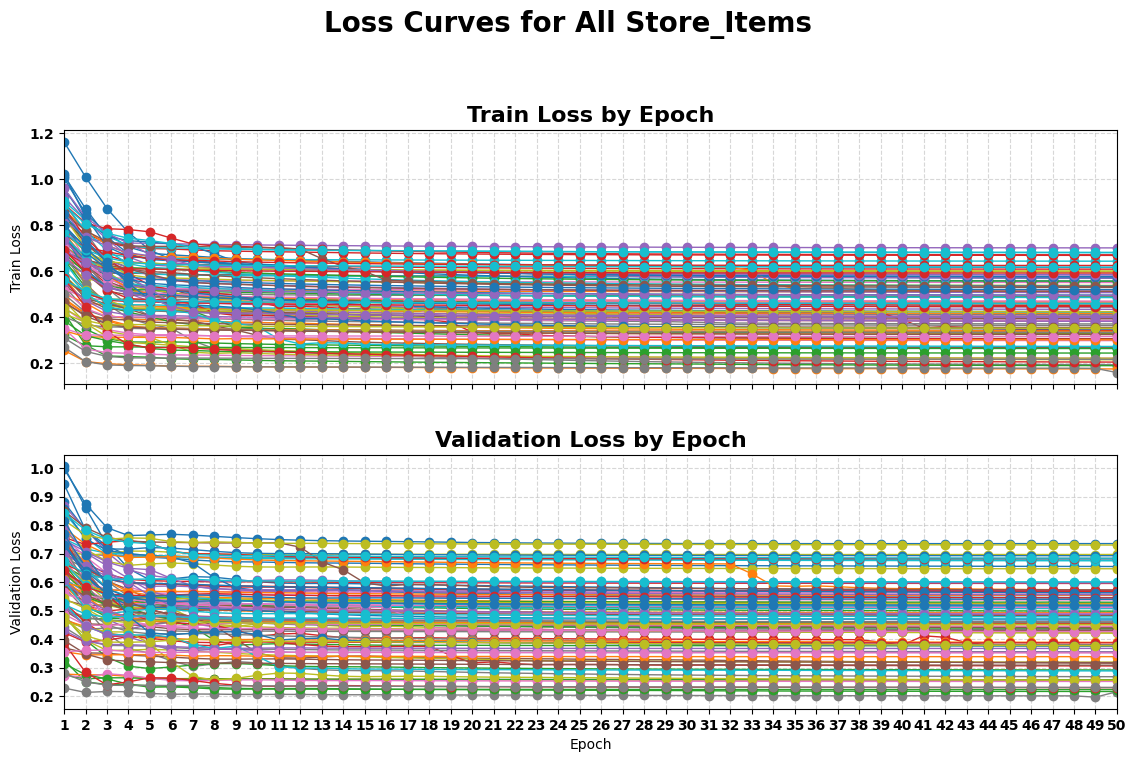

In [15]:
# Example usage:
plot_all_sids_losses(hist_df, 
                     overall_title="Loss Curves for All Store_Items",
fn=f"../output/figures/all_sids_loss_curves_.tiff")


max_epoch: 50


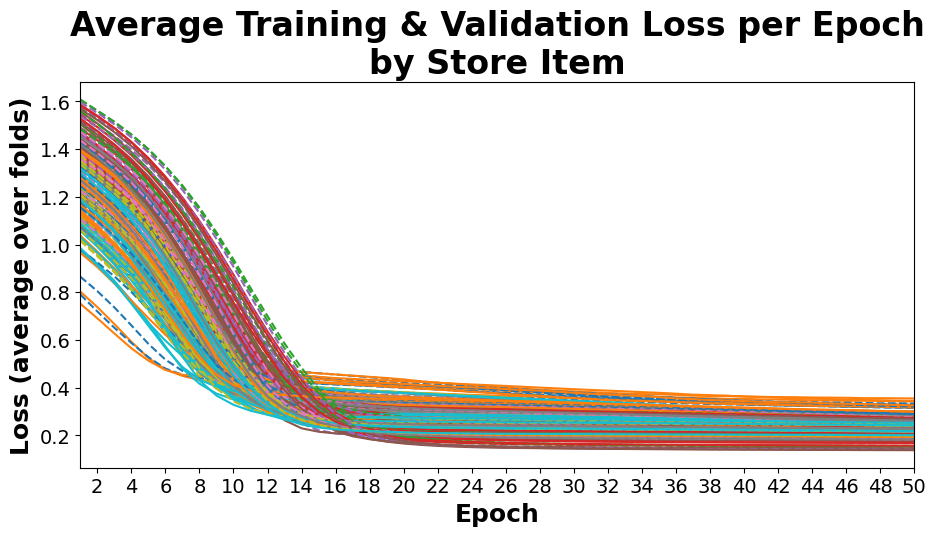

In [39]:
# 1) Compute per‐store, per‐epoch averages across folds
max_epoch = history_df['epoch'].max()
print(f"max_epoch: {max_epoch}")
# 1) Compute per‐store, per‐epoch averages across folds
avg_hist = (
    history_df
      .groupby(['store_item','epoch'], as_index=False)
      .agg({
          'train_loss': 'median',
          'val_loss':   'median'
      })
)
avg_hist = avg_hist[avg_hist['epoch'] <= max_epoch]


# 2) Plot
plt.figure(figsize=(10,6))


for sid, grp in avg_hist.groupby('store_item'):
    plt.plot(
        grp['epoch'], grp['train_loss'],
        linestyle='--', label=f'{sid} Train'
    )
    plt.plot(
        grp['epoch'], grp['val_loss'],
        linestyle='-', label=f'{sid} Val'
    )

plt.xlabel('Epoch', fontsize=18, fontweight="bold")
plt.ylabel('Loss (average over folds)', fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Average Training & Validation Loss per Epoch\nby Store Item',
    fontsize=24,       # or whatever size you prefer
    fontweight='bold'  # or weight='bold'
)

# limit x-axis
plt.xlim(1, max_epoch)
# set x‑axis major ticks every 2
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2))

# make legend font small
# plt.legend(
#     bbox_to_anchor=(1.01,1), loc='upper left', ncol=1,
#     fontsize=3       # or a numeric value like 8
# )
plt.tight_layout(pad=3.0)
plt.savefig("../output/figures/20250513_store_item_validation_loss.tiff", dpi=300, bbox_inches="tight")
plt.show()
plt.close() 



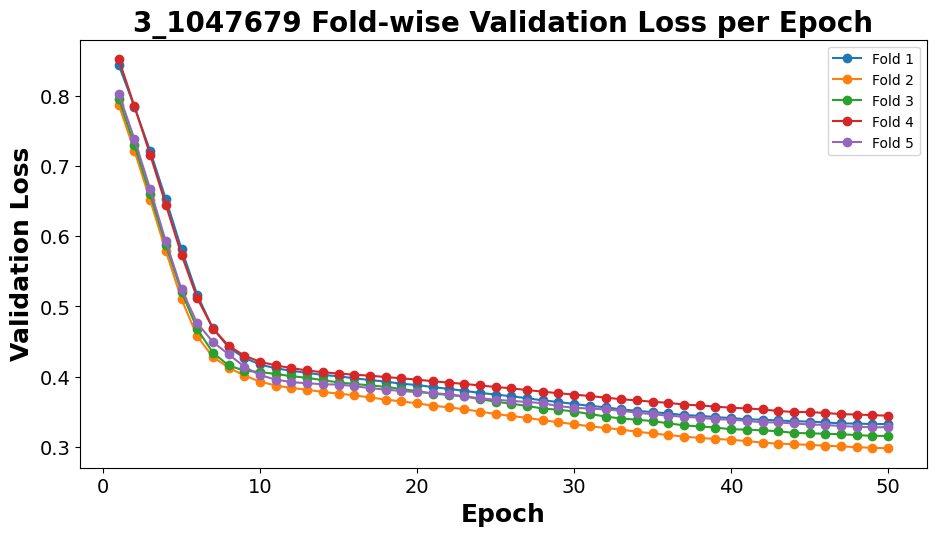

In [40]:
plt.figure(figsize=(10,6))
sid = "3_1047679"
h = history_df[history_df['store_item']==sid]

for fold, grp in h.groupby('fold'):
    # if fold == 4:
    #     continue
    plt.plot(
        grp['epoch'],
        grp['val_loss'],
        marker='o',
        label=f'Fold {fold}'
    )

plt.xlabel('Epoch', fontsize=18, fontweight="bold")
plt.ylabel('Validation Loss', fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    f'{sid} Fold‑wise Validation Loss per Epoch',
    fontsize=20,       
    fontweight='bold' 
)

plt.legend()
plt.tight_layout(pad=3.0)
plt.savefig("../output/figures/20250513_store_item_3_1047679_validation_loss.tiff", dpi=300, bbox_inches="tight")
plt.show()
plt.close() 

In [41]:
all_results

{'3_1047679': {'models': [ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
    